In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

/tmp/ipykernel_797504/3849965675.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', N + 1)  # N malware families + 1 benign


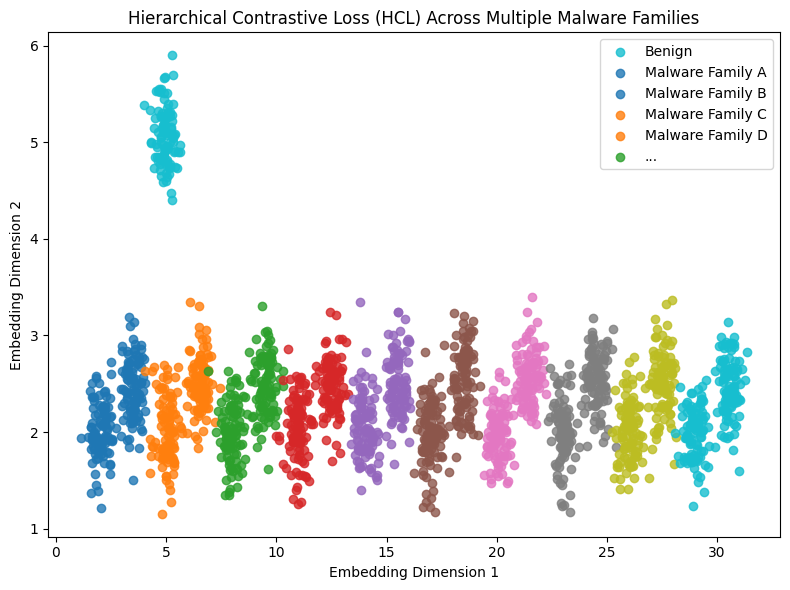

In [6]:
N = 20
samples_per_class = 100
benign_center = np.array([5, 5])
malware_centers = [np.array([2 + i*1.5, 2 + (i % 2) * 0.5]) for i in range(N)]
colors = plt.cm.get_cmap('tab10', N + 1)  # N malware families + 1 benign

data = []
labels = []

for i in range(N):
    cluster = np.random.normal(loc=malware_centers[i], scale=0.3, size=(samples_per_class, 2))
    data.append(cluster)
    labels.extend([f"Malware Family {chr(65+i)}"] * samples_per_class)

benign = np.random.normal(loc=benign_center, scale=0.3, size=(samples_per_class, 2))
data.append(benign)
labels.extend(["Benign"] * samples_per_class)

plt.figure(figsize=(8, 6))
for i, cluster in enumerate(data):
    label = labels[i * samples_per_class]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=label, alpha=0.8, color=colors(i))

plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Hierarchical Contrastive Loss (HCL) Across Multiple Malware Families")
plt.grid(True)
plt.tight_layout()

# legend filtering (before show)
handles, labels = plt.gca().get_legend_handles_labels()
max_families = 5
labels[max_families - 1] = "..."
filtered = []
added_labels = set()

for h, l in zip(handles, labels):
    if l == "Benign":
        filtered.insert(0, (h, l)) 
    elif len(added_labels) < max_families and l not in added_labels:
        filtered.append((h, l))
        added_labels.add(l)

if filtered:  # avoid ValueError
    filtered_handles, filtered_labels = zip(*filtered)
    plt.legend(filtered_handles, filtered_labels, loc='upper right')

plt.grid(False)

plt.show()